les pip :
spacy
spacy-lefff
git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
pandas pyarrow
(pandas fast parquet)

le reste :
spacy download fr_core_news_sm 

In [2]:
import s3fs 
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "arnaudbrrt"
FILE_PATH_IN_S3 = f"{MY_BUCKET}/diffusion/df_books.csv"
with fs.open(FILE_PATH_IN_S3, "r") as file_in:
    df_books = pd.read_csv(file_in)
df_books

NameError: name 'pd' is not defined

In [1]:
#Imports
import spacy 
#from spacy_lefff import LefffLemmatizer --> utile ?
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#Reader/set up
#lire csv
bla=pd.read_csv("/home/onyxia/libroguessr/Data/base_csv_final.csv")
texts=list(bla["Texte"])
#table=pd.Dataframe(data=, columns=["Titre","Texte"])
nlp = spacy.load("fr_core_news_sm")  #modèle français
stop_words_fr = nlp.Defaults.stop_words #liste de stopwords fr


Les fonctions

In [1]:
#Spacy lemmatizer --> plus de nc
def lemmatizer (txt) :
    txt_lemma =[(t.lemma_,t.tag_) for t in nlp(txt)]
    txt_lemma = [t for t in txt_lemma if t[0] not in stop_words_fr]#lemmes sans les stopswords

    
    return txt_lemma #peu précis (NP pas tj reconnus, vb quand faut pas...)

#Claude Coulombe lemmatizer (with spacy-lefff) --> plus de vb
def CC_lemmatizer (txt) :
    txt_token =[t.text for t in nlp(txt)]# if t.text not in stop_words_fr]#mieux que juste split et stop_words pour éviter des erreurs de lecture
    lemmatizer = FrenchLefffLemmatizer()
    lemma_CC=[lemmatizer.lemmatize(t,'all')[0] for t in txt_token if len(lemmatizer.lemmatize(t,'all'))!=0]#cette fonction prend les textes et non la version fr_core_news_sm
    txt_lemma_CC=[t for t in lemma_CC if t[0] not in stop_words_fr]#que lemmes CC
    return txt_lemma_CC #meilleur mais perte des chiffres

#Turns tokens into ngrams
def generate_ngrams (tokens, n):
    
    # Replace all non-alphanumeric characters with spaces
  
    tokens = [re.sub(r'[^a-zA-Z0-9\u00C0-\u00FF]', '', s) for s in tokens]
    # s = s.replace('\n', '').replace('\r', '') #for some reason the above line could not raise \n and \r
    tokens=list(filter(None, tokens))
    # Break sentence in the token, remove empty tokens
    #tokens = [token for token in tokens.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

#Implement ngrams
def add_ngrams (t_type, t_lemma, n, t_text=None) : #option t_text pour faire des ngrams avec le texte original
    size=len(t_lemma)
    if t_text==None : 
        t_lemma.append(generate_ngrams(t_lemma,n))#adds ngrams
    else : 
        t_lemma.append(generate_ngrams(t_text,n))#adds ngrams
    t_lemma=[item for sublist in t_lemma for item in (sublist if isinstance(sublist, list) else [sublist])]#flatten
    t_type.append([(x, 'ngram') for x in t_lemma[size:len(t_lemma)]])#adds ngram type
    t_type=[item for sublist in t_type for item in (sublist if isinstance(sublist, list) else [sublist])]#flatten
    return (t_type)

#Stats
def summary_table (txt_type,txt_lemma, id) :       
    d_type=pd.DataFrame(data=txt_type, columns=['Word','Type'])
    tk_count=Counter(txt_lemma)
    d_count=pd.DataFrame.from_dict(data=tk_count,orient='index',columns=["Count"])
    d_count=d_count.reset_index()
    d_count=d_count.rename(columns={"index":"Word"})
    d_final=d_type.merge(d_count,on='Word')
    d_final["Type_factor"]=pd.factorize(d_final["Type"])[0] + 1
    d_final["Order"]=d_final.index
    d_final=d_final.drop_duplicates(subset=['Word'])#deletes redundancies
    return d_final.assign(Id=id)

#matrix utile ?
def matrix (d, word="Word",param=["Count","Type_factor","Order"]) : #param are the parameters of each word, by default it contains the type and the frequence
    d=d.pivot_table(index=None, columns=word, values=param, aggfunc="first")
    return d

#make a dictionary that keeps the titles or add a column

#TfIdf
def Tf_Idf (sums,lemmas) :
    voc=pd.DataFrame(columns=['Word'])
    for s in sums :
        voc = pd.concat([voc,s[['Word']]], ignore_index=True)
    voc=voc['Word'].unique().tolist()
    vectorizer = TfidfVectorizer(lowercase=False, vocabulary=voc, min_df=2)
    #print(len([term for term in voc if Counter(voc)[term] > 1]))
    vectors=[]
    for l in lemmas :
        X = vectorizer.fit_transform([" ".join(w) for w in l])#aussi possib de faire X.toarray()
        vectors.append(X)
    return vectors

def parquet (data, name) : 
    full=[]
    for d in data : 
        full.append(d)
    file=pd.concat(full, ignore_index=True)
    file.to_parquet(f'/home/onyxia/libroguessr/Data/{name}.parquet', engine='pyarrow')


In [2]:
nlp.max_length=100000000
t_lemmas=[]
t_sums=[]
for idx,txt in enumerate(texts[10:19]) : 
    sample_type_CC,sample_lemma_CC=(CC_lemmatizer(txt),[t[0] for t in CC_lemmatizer(txt)])
    sample_type_extended,sample_extended=(add_ngrams(sample_type_CC,sample_lemma_CC,2,[t.text for t in nlp(txt)]),[t[0] for t in add_ngrams(sample_type_CC,sample_lemma_CC,2,[t.text for t in nlp(txt)])])
    d=pd.DataFrame(columns={"Lemmes": sample_extended})
    t_lemmas.append(d.assign(Id=idx))
    d_sum_extended=summary_table(sample_type_extended,sample_extended, idx)
    t_sums.append(d_sum_extended)


NameError: name 'nlp' is not defined

In [ ]:
parquet(t_lemmas,'lemmes_2')
parquet(t_sums,'summary_2')

In [ ]:
#ICI arnaud
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
#TfIdf
def Tf_Idf (sums,lemmas) :
    voc=pd.DataFrame(columns=['Word'])
    for s in sums :
        voc = pd.concat([voc,s[['Word']]], ignore_index=True)
    voc=voc['Word'].unique().tolist()
    vectorizer = TfidfVectorizer(lowercase=False, vocabulary=voc, min_df=2)
    #print(len([term for term in voc if Counter(voc)[term] > 1]))
    vectors=[]
    for l in lemmas :
        X = vectorizer.fit_transform([" ".join(w) for w in l])#aussi possib de faire X.toarray()
        vectors.append(X)
    return vectors

In [ ]:
t_lemmas=[v for k, v in pd.read_parquet('/home/onyxia/libroguessr/Data/lemmes.parquet', engine='pyarrow').groupby('Id')]
t_sums=[v for k, v in pd.read_parquet('/home/onyxia/libroguessr/Data/summary.parquet', engine='pyarrow').groupby('Id')]
vec=Tf_Idf(t_sums,t_lemmas)

In [ ]:
parquet(vec)

In [6]:
#Execution --> CC_lemma+2-grams with original text
sample_txt=texts[8]
sample_type_CC,sample_lemma_CC=(CC_lemmatizer(sample_txt),[t[0] for t in CC_lemmatizer(sample_txt)])
sample_type_extended,sample_extended=(add_ngrams(sample_type_CC,sample_lemma_CC,2,[t.text for t in nlp(sample_txt)]),[t[0] for t in add_ngrams(sample_type_CC,sample_lemma_CC,2,[t.text for t in nlp(sample_txt)])])
d_sum_extended=summary_table(sample_type_extended,sample_extended,8)
m_final=matrix(d_sum_extended)

print(d_sum_extended[150:160])
print(d_sum_extended.sample(10))
print(m_final)



#print(sample_lemma[1400:1415],"\n",sample_lemma_CC[4010:4020], "\n", sample_extended[6000:6015])



          Word Type  Count  Type_factor  Order  Id
252   brancher    v     18            5    252   8
253     tomber    v     54            5    253   8
254   charmant  adj      8            7    254   8
255  fraîcheur   nc      2            6    255   8
256   feuiller    v     17            5    256   8
258      rayon   nc     15            6    258   8
259     soleil   nc     37            6    259   8
260     trouer    v      5            5    260   8
261    ténèbre   nc     26            6    261   8
262       vert  adj      7            7    262   8
                             Word   Type  Count  Type_factor   Order  Id
169795                  ne grimpe  ngram      3           16  169795   8
95893                  s orienter  ngram      9           16   95893   8
1822                       casser      v     13            5    1822   8
166578                   sera ici  ngram      3           16  166578   8
181640                  Un absolu  ngram      3           16  181640   8
8

Textes trop longs parfois faire gaffe --> max 1M ou aug max avec nlp.max_length

Tests

In [ ]:
def Tf_Idf (sums,lemmas) :
    voc=pd.DataFrame(columns='Word')
    for s in sums : 
        voc = pd.concat([init, s['Word']], ignore_index=True)
    vectorizer = TfidfVectorizer(lowercase=False, vocabulary=voc)
    vectors=[]
    for l in lemmas :
        X = vectorizer.fit_transform([" ".join(w) for w in l])#aussi possib de faire X.toarray()
        vectors.append(X)
    return vectors


print("Shape of X:", X.shape)

# 2. Number of non-zero elements in the matrix
print("Number of non-zero elements:", X.nnz)

# 3. Vocabulary (terms) corresponding to the columns
vocabulary_terms = vectorizer.get_feature_names_out()
print("Vocabulary terms:", vocabulary_terms)


In [ ]:
#mots/lemma/mots+phrases/lemma+phrases
#tf-idf
#nlp.add_pipe("sentencizer")

bla=" ".join(x for x in sample_lemma_CC)
bla=sample_txt
doc = list( x.text for x in nlp(bla) if not x.is_punct)
doc=" ".join(x for x in doc)


#nlp.add_pipe("merge_noun_chunks")
#for sent in doc.sents:
#    print(sent.vector,"///")

#for chunk in doc.noun_chunks:
#   print(chunk.text,"///", chunk.root.head.text, "///")
#doc.similarity(nlp(sample_txt))    , chunk.root.text, chunk.root.dep_,
#          chunk.root.head.text,
#print(doc.sents)
#print([(i, i.label_, i.label) for i in doc.ents])
print(nlp(doc))


for noun_phrase in list(nlp(doc).noun_chunks):
    print((noun_phrase.root.tag_, noun_phrase.root.lemma_, noun_phrase.root.ent_type_))
 
print([(token.text,token.pos_) for token in doc])

Le malheureux Dantès désespère dans sa captivité pendant 4 ans jusqu' à songer au suicide Il a la chance de faire la connaissance de l'abbé Faria un autre prisonnier qui voulant s' évader a creusé un tunnel qui débouche non sur la mer mais dans la cellule de Dantès et sauve Dantès qui se laissait mourir de faim Edmond Dantès découvre alors en l'abbé Faria une personne exceptionnelle érudit dans tous les domaines scientifiques et philosophiques L'abbé Faria fait la lumière sur le complot machiné contre Edmond en lui montrant son écriture de la main gauche qui ressemble étrangement à celle de la lettre et en lui expliquant que M. Noirtier est en réalité le père de Villefort Ces révélations instillent la vengeance dans le cœur d' Edmond L'abbé Faria très érudit se lie d' amitié avec Dantès et lui donne une éducation exceptionnelle tant en économie qu'en sciences en politique en philosophie mais aussi en langues Faria fait une première crise de catalepsie qui le laisse paralysé d' un bras 

AttributeError: 'str' object has no attribute 'text'

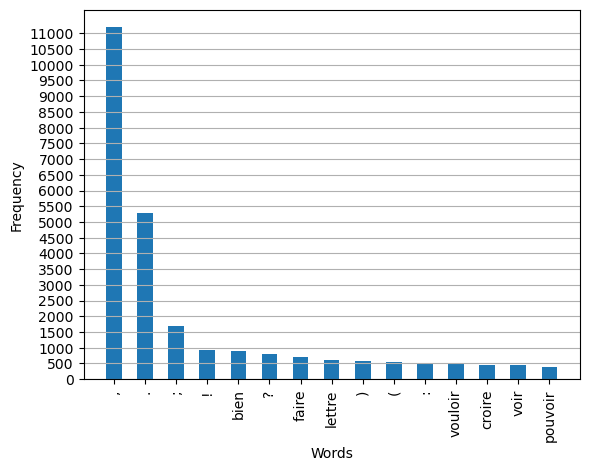

In [58]:
#Graphs
#plt.hist(d_sum_CC)
d_sorted=d_sum_CC.sort_values('Count',ascending=False).head(15)
plt.bar(d_sorted['Word'], d_sorted['Count'], width=0.5)
plt.xticks(rotation='vertical')
plt.yticks(range(0,max(d_sorted['Count']),500))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()

In [ ]:
"""
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("genesis")
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.stem import WordNetLemmatizer
"""
#pas sûr de l'utilité de nltk


"""
pos = POSTagger()
french_lemmatizer = LefffLemmatizer(after_melt=True)
nlp.add_pipe(name='pos', after='parser')
nlp.add_pipe(french_lemmatizer, name='lefff', after='pos')

test=[d._.lefff_lemma for d in txt]
from spacy_lefff import LefffLemmatizer,POSTagger
test


french_lemmatizer = LefffLemmatizer(after_melt=True)
"""

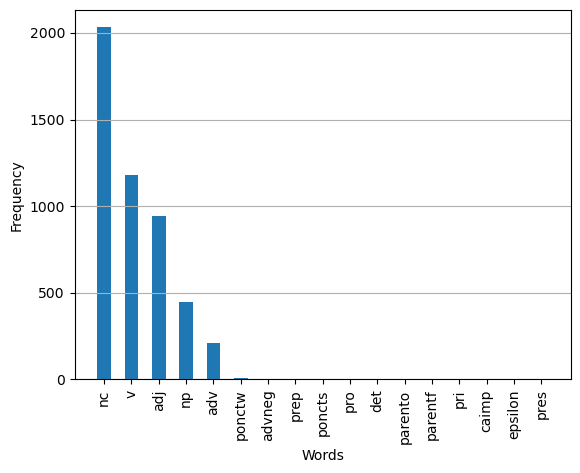

In [59]:
d=d_sum_CC['Type'].value_counts()
plt.bar(d.index, d.values, width=0.5)
plt.xticks(rotation='vertical')
plt.yticks(range(0,max(d_sum_CC['Type'].value_counts().values),500))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()